In [1]:
pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cudf
import cupy

from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from google.colab import drive
from collections import Counter
from joblib import dump

ModuleNotFoundError: No module named 'cudf'

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For XGBoost, we are going to perform a randomized search, due to hardware and time limitations. First, we are going to prepare the data by loading it and converting the categorical features to string, so that the model doesn't confuse them as numerical

In [4]:
X_train_pd = pd.read_csv("/content/drive/MyDrive/road_accidents/X_train_new.csv", index_col = 0)
y_train_pd = pd.read_csv("/content/drive/MyDrive/road_accidents/y_train_new.csv", index_col = 0)

X_test_pd = pd.read_csv("/content/drive/MyDrive/road_accidents/X_test_new.csv", index_col = 0)
y_test_pd = pd.read_csv("/content/drive/MyDrive/road_accidents/y_test_new.csv", index_col = 0)

In [5]:
categorical_features = ["day_of_week", "first_road_class", "road_type", "junction_detail",
                   "second_road_class", "pedestrian_crossing_human_control",
                   "pedestrian_crossing_physical_facilities", "light_conditions", "weather_conditions",
                   "road_surface_conditions", "special_conditions_at_site", "carriageway_hazards",
                   "did_police_officer_attend_scene_of_accident", "vehicle_type", "towing_and_articulation",
                   "vehicle_manoeuvre", "vehicle_location_restricted_lane", "junction_location",
                   "skidding_and_overturning", "hit_object_in_carriageway", "hit_object_off_carriageway",
                   "vehicle_leaving_carriageway", "first_point_of_impact", "sex_of_driver", "vehicle_left_hand_drive",
                   "journey_purpose_of_driver", "casualty_class", "sex_of_casualty",
                   "pedestrian_location", "pedestrian_movement", "car_passenger", "bus_or_coach_passenger",
                   "pedestrian_road_maintenance_worker", "vehicle_direction_from", "vehicle_direction_to",
                   "age_band_of_casualty", "day_of_month", "month", "time_rounded",]

In [6]:
for col in categorical_features:
    X_train_pd[col] = X_train_pd[col].astype("category")
    X_test_pd[col] = X_test_pd[col].astype("category")

We would have to perform several adjustments to the data in order to make it work with XGBoost:

In [7]:
y_train_pd["accident_severity"] = y_train_pd["accident_severity"].replace({1: 0, 2: 1, 3: 2})
y_test_pd["accident_severity"] = y_test_pd["accident_severity"].replace({1: 0, 2: 1, 3: 2})

XGBoost accepts a parameter, called "class_weights", which tries to handle the class imbalance automatically.

In [3]:
class_weights = compute_class_weight(class_weight='balanced',
                                       classes=np.unique(y_train_pd['accident_severity']),
                                       y=y_train_pd['accident_severity'])
class_weights_dict = dict(enumerate(class_weights))

In [9]:
sample_weights_train = [class_weights_dict[label] for label in y_train_pd['accident_severity']]

In [10]:
param_distributions = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'tree_method': ['hist'],
    'device' : ['cuda']
}

These adjustments were made to utilize the A100 GPU.

In [11]:
 X_train = cudf.from_pandas(X_train_pd)
 y_train = cudf.from_pandas(y_train_pd)
 X_test = cudf.from_pandas(X_test_pd)
 y_test = cudf.from_pandas(y_test_pd)

 sample_weights_train_gpu = cupy.asarray(sample_weights_train)


In [12]:
xgb_model = XGBClassifier(random_state=42, enable_categorical = True, objective='multi:softmax')

In [13]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=40,
    scoring='f1_weighted',
    cv=3,
    verbose=3,
    n_jobs=1
)

In [14]:
random_search.fit(X_train, y_train.to_cupy().get(), sample_weight=sample_weights_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END colsample_bytree=1.0, device=cuda, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, subsample=0.7, tree_method=hist;, score=0.656 total time=   4.5s
[CV 2/3] END colsample_bytree=1.0, device=cuda, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, subsample=0.7, tree_method=hist;, score=0.656 total time=   3.8s
[CV 3/3] END colsample_bytree=1.0, device=cuda, gamma=0, learning_rate=0.05, max_depth=3, n_estimators=500, subsample=0.7, tree_method=hist;, score=0.655 total time=   3.8s
[CV 1/3] END colsample_bytree=0.7, device=cuda, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0, tree_method=hist;, score=0.657 total time=   2.4s
[CV 2/3] END colsample_bytree=0.7, device=cuda, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0, tree_method=hist;, score=0.656 total time=   2.4s
[CV 3/3] END colsample_bytree=0.7, device=cuda, gamma=5, learning_rate=0.1,

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softmax', ...),
                   n_iter=40, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'device': ['cuda'], 'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.7, 0.8, 1.0],
                                        'tree_method': ['hist']},
                   scoring='f1_weighted', verbose=3)

In [18]:
print("Best Parameters:", random_search.best_params_)

# Best score
print("Best Score:", random_search.best_score_)

# Best model
best_xgboost_model = random_search.best_estimator_

Best Parameters: {'tree_method': 'hist', 'subsample': 0.7, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'device': 'cuda', 'colsample_bytree': 0.8}
Best Score: 0.7755920282500351


Looking at the best metrics, although they would be explored again in the main notebook

In [20]:
best_xgboost_model.score(X_train, y_train_pd)

0.9081302989736725

In [21]:
best_xgboost_model.score(X_test, y_test_pd)

0.7713520749665328

In [22]:
y_pred = best_xgboost_model.predict(X_test)

In [26]:
print(classification_report(y_test_pd, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53      2367
           1       0.50      0.63      0.56     25007
           2       0.88      0.82      0.85     84676

    accuracy                           0.77    112050
   macro avg       0.65      0.65      0.65    112050
weighted avg       0.79      0.77      0.78    112050



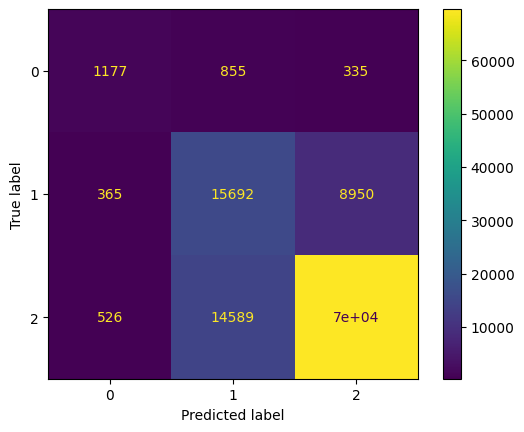

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test_pd, y_pred)
plt.show()

Saving the model:

In [34]:
dump(best_xgboost_model, "/content/drive/MyDrive/road_accidents/best_xgboost_model_randomized_search.joblib")

['/content/drive/MyDrive/road_accidents/best_xgboost_model_randomized_search.joblib']

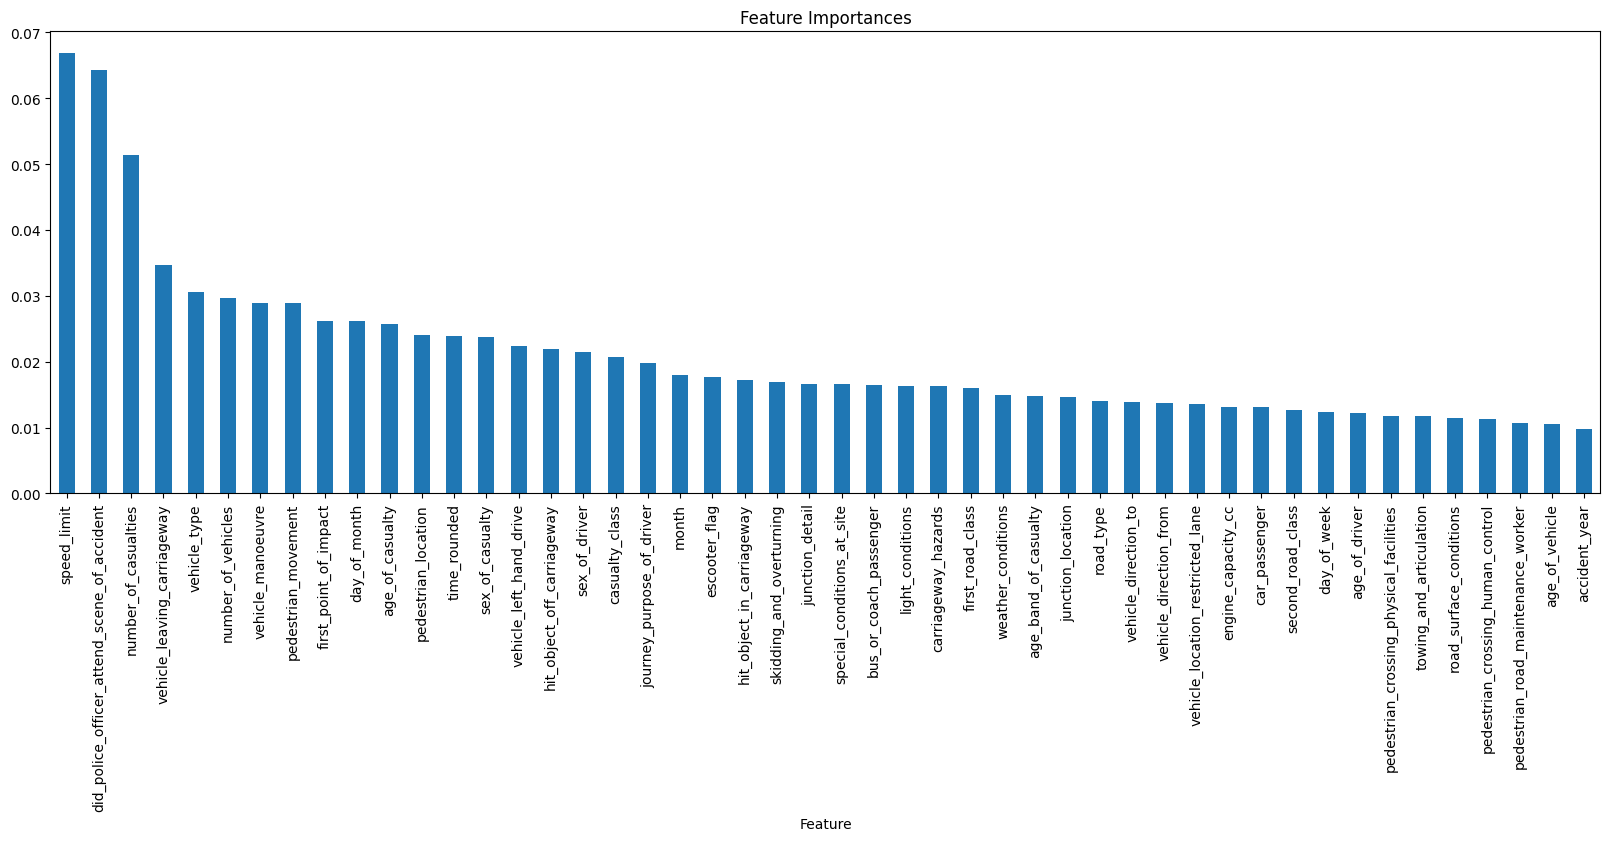

In [45]:
importance_df = pd.DataFrame({
    "Feature": X_train_pd.columns,
    "Importance": best_xgboost_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False, figsize=(20, 6))
plt.title("Feature Importances")
plt.show()

Here, as opposed to CatBoost, the most important feature is the speed limit, which we've already explored. We are going to explore the other ones further on.